# Exploratory Data Analysis
##### Mansa Kanedama, Oscar Gilg

The first part of any data science project is to explore the data. In this case I would like to answer 2 questions:
- Is this problem suited to timeseries forecasting, or is a classic regression model preferable?
- In what format does it make sense to store the data in order to easily and accurately train models?
- What can I engineer from the NAF code and how can I encode it?
- Which of option A or B is more ineresting and useful to model?

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
transactions = pd.read_csv(os.path.join('data', 'transactions.csv'))
# convert date column to np.datetime64
transactions.date = pd.to_datetime(transactions.date, format="%Y/%m/%d")
accounts = pd.read_csv(os.path.join('data', 'accounts.csv'))
users = pd.read_csv(os.path.join('data', 'users.csv'))
users.update_date = pd.to_datetime(users.update_date, format="%Y/%m/%d")

In [3]:
business_naf = pd.read_csv(os.path.join('data', 'business_NAF.csv'),sep=';')

In [4]:
users

,id,update_date,business_NAF_code
0,0,2020-09-27,8219Z
1,1,2020-09-27,6201Z
2,2,2020-09-27,6201Z
3,3,2020-09-27,6201Z
4,4,2020-09-27,6201Z
...,...,...,...
338,338,2020-09-26,4719B
339,339,2020-09-26,4331Z
340,340,2020-09-27,5320Z
341,341,2020-09-27,2562B


In [5]:
accounts

,id,balance,user_id
0,0,3000.00,112
1,1,-465.66,112
2,2,372.81,104
3,3,229.73,198
4,4,1998.48,316
...,...,...,...
436,436,-16.90,326
437,437,-1686.06,50
438,438,-343.06,284
439,439,146.71,77


Some users have two accounts, in which case there is clearly a main and a secondary account. We can merge the two accounts into one history dataframe.

### Creating a User class

The prediction task is centered around individual users, hence the data used to train our model will be of the form: X = user_data, y = user income/expenses.

For this reason creating a User class to encapsulate a user's information will be helpful for reasoning about the modeling part of the problem.
Encapsulates a user and their data

       + pd.DataFrame for user history containing:
           - Balance history (reverse balance by looking at transactions)
           - Transaction history
       + Extra features(num transactions, std transactions...)
       + NAF code with feature engineering 
      

Have to cd up one directory to resolve importing conflicts with PyCharm

In [6]:
cd ..

C:\Users\oscar\PycharmProjects\kanedama


In [7]:
from src.user_data.User import User

In [8]:
def get_naf_code(user_id):
    return users.loc[users['id'] == user_id]['business_NAF_code'].values[0]

In [9]:
u = User(5, accounts, transactions, get_naf_code(5))
hist = u.account_history

### UserDataExtractor: Extracting relevant data from users

The UserDataExtractor class takes a user as argument and extracts the relevant data from it as follows:
    - It fills in the missing days in the history in the appropriate way
    - Aggregates by day when several transactions happen on the same day
This is in some sense inefficient, but it makes it much easier for me to quickly run experiments on different timeframes rather than committing to constraints in the code too early.

UserDataExtractor will also evetually contain a method for packaging up the data in a DataFrame.

Why use 2 classes? The User class encapsulates data relevant to the user in general, the UserDataExtractor encapsulates data relevant to this specific problem i.e. predicting income and/or expense in the next month.

In [12]:
from src.user_data.UserDataExtractor import UserDataExtractor

In [13]:
u = User(4, accounts, transactions, get_naf_code(4))

In [15]:
v = UserDataExtractor(u)
filled_hist = v.filled_history

In [16]:
filled_hist

,amount,balance
date,,
2018-02-09,997.76,-33.14
2018-02-10,0.00,964.62
2018-02-11,0.00,964.62
2018-02-12,-10.80,964.62
2018-02-13,-17.99,953.82
...,...,...
2020-09-15,0.00,1630.92
2020-09-16,0.00,1630.92
2020-09-17,0.00,1630.92


It is now easier to plot the data

<AxesSubplot:xlabel='date'>

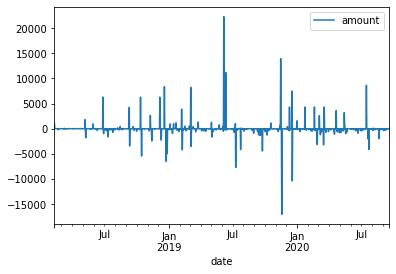

In [16]:
filled_hist.plot(y='amount')

<AxesSubplot:xlabel='date'>

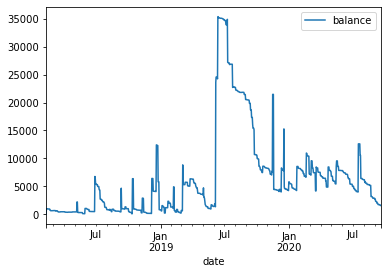

In [17]:
filled_hist.plot(y='balance')

##### Plotting transactions for 100 users

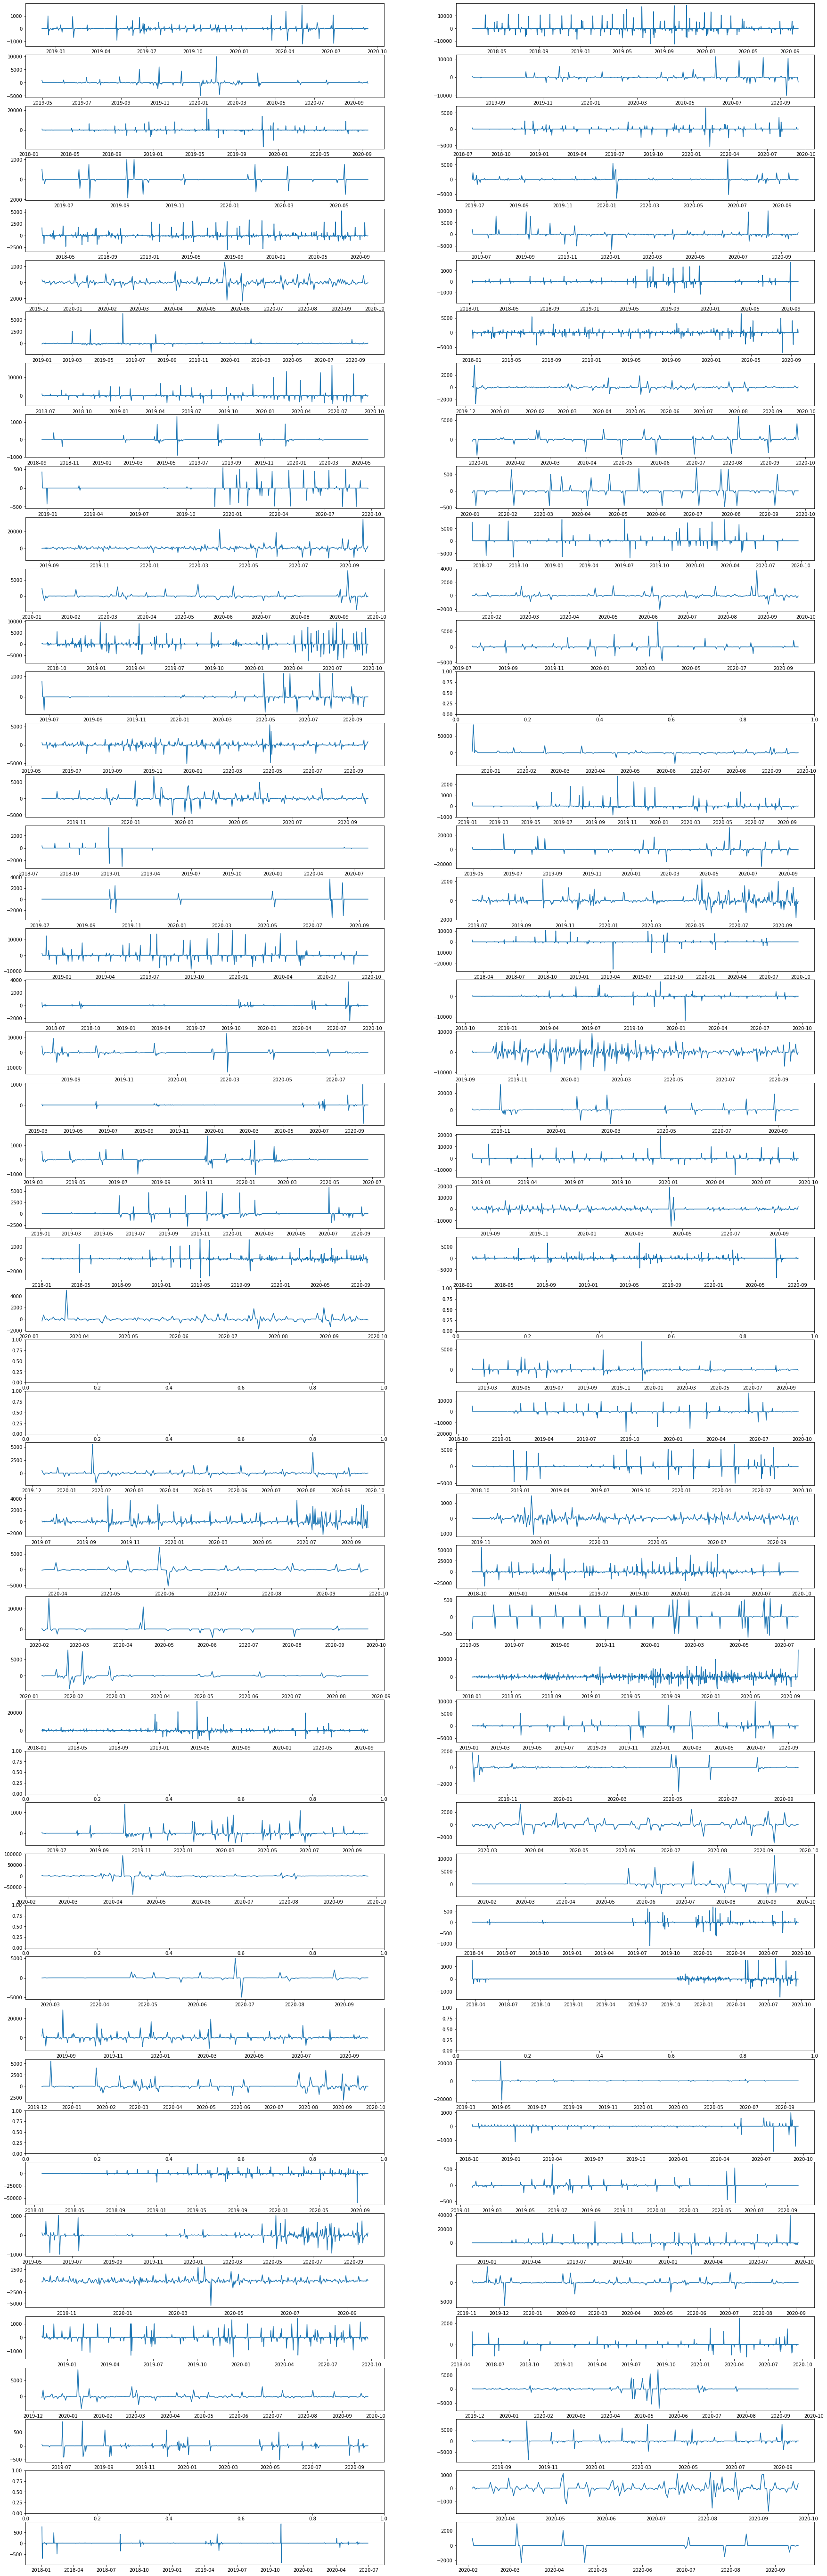

In [17]:
per_row = 2
rows = 50
fig, axs = plt.subplots(rows,per_row, figsize=(30,rows*2))
for user_id in range(rows*per_row):
    u = User(user_id, accounts, transactions, get_naf_code(user_id))
    # only select users with sufficient history, plots will show up blank
    if u.get_history_length() < 180 or len(u.account_history) < 20:
        continue
    v = UserDataExtractor(u)
    filled_hist = v.filled_history
    axs[int(user_id/per_row),user_id%per_row].plot(filled_hist.index, filled_hist['amount'])


#### Plotting monthly expenses for 100 users

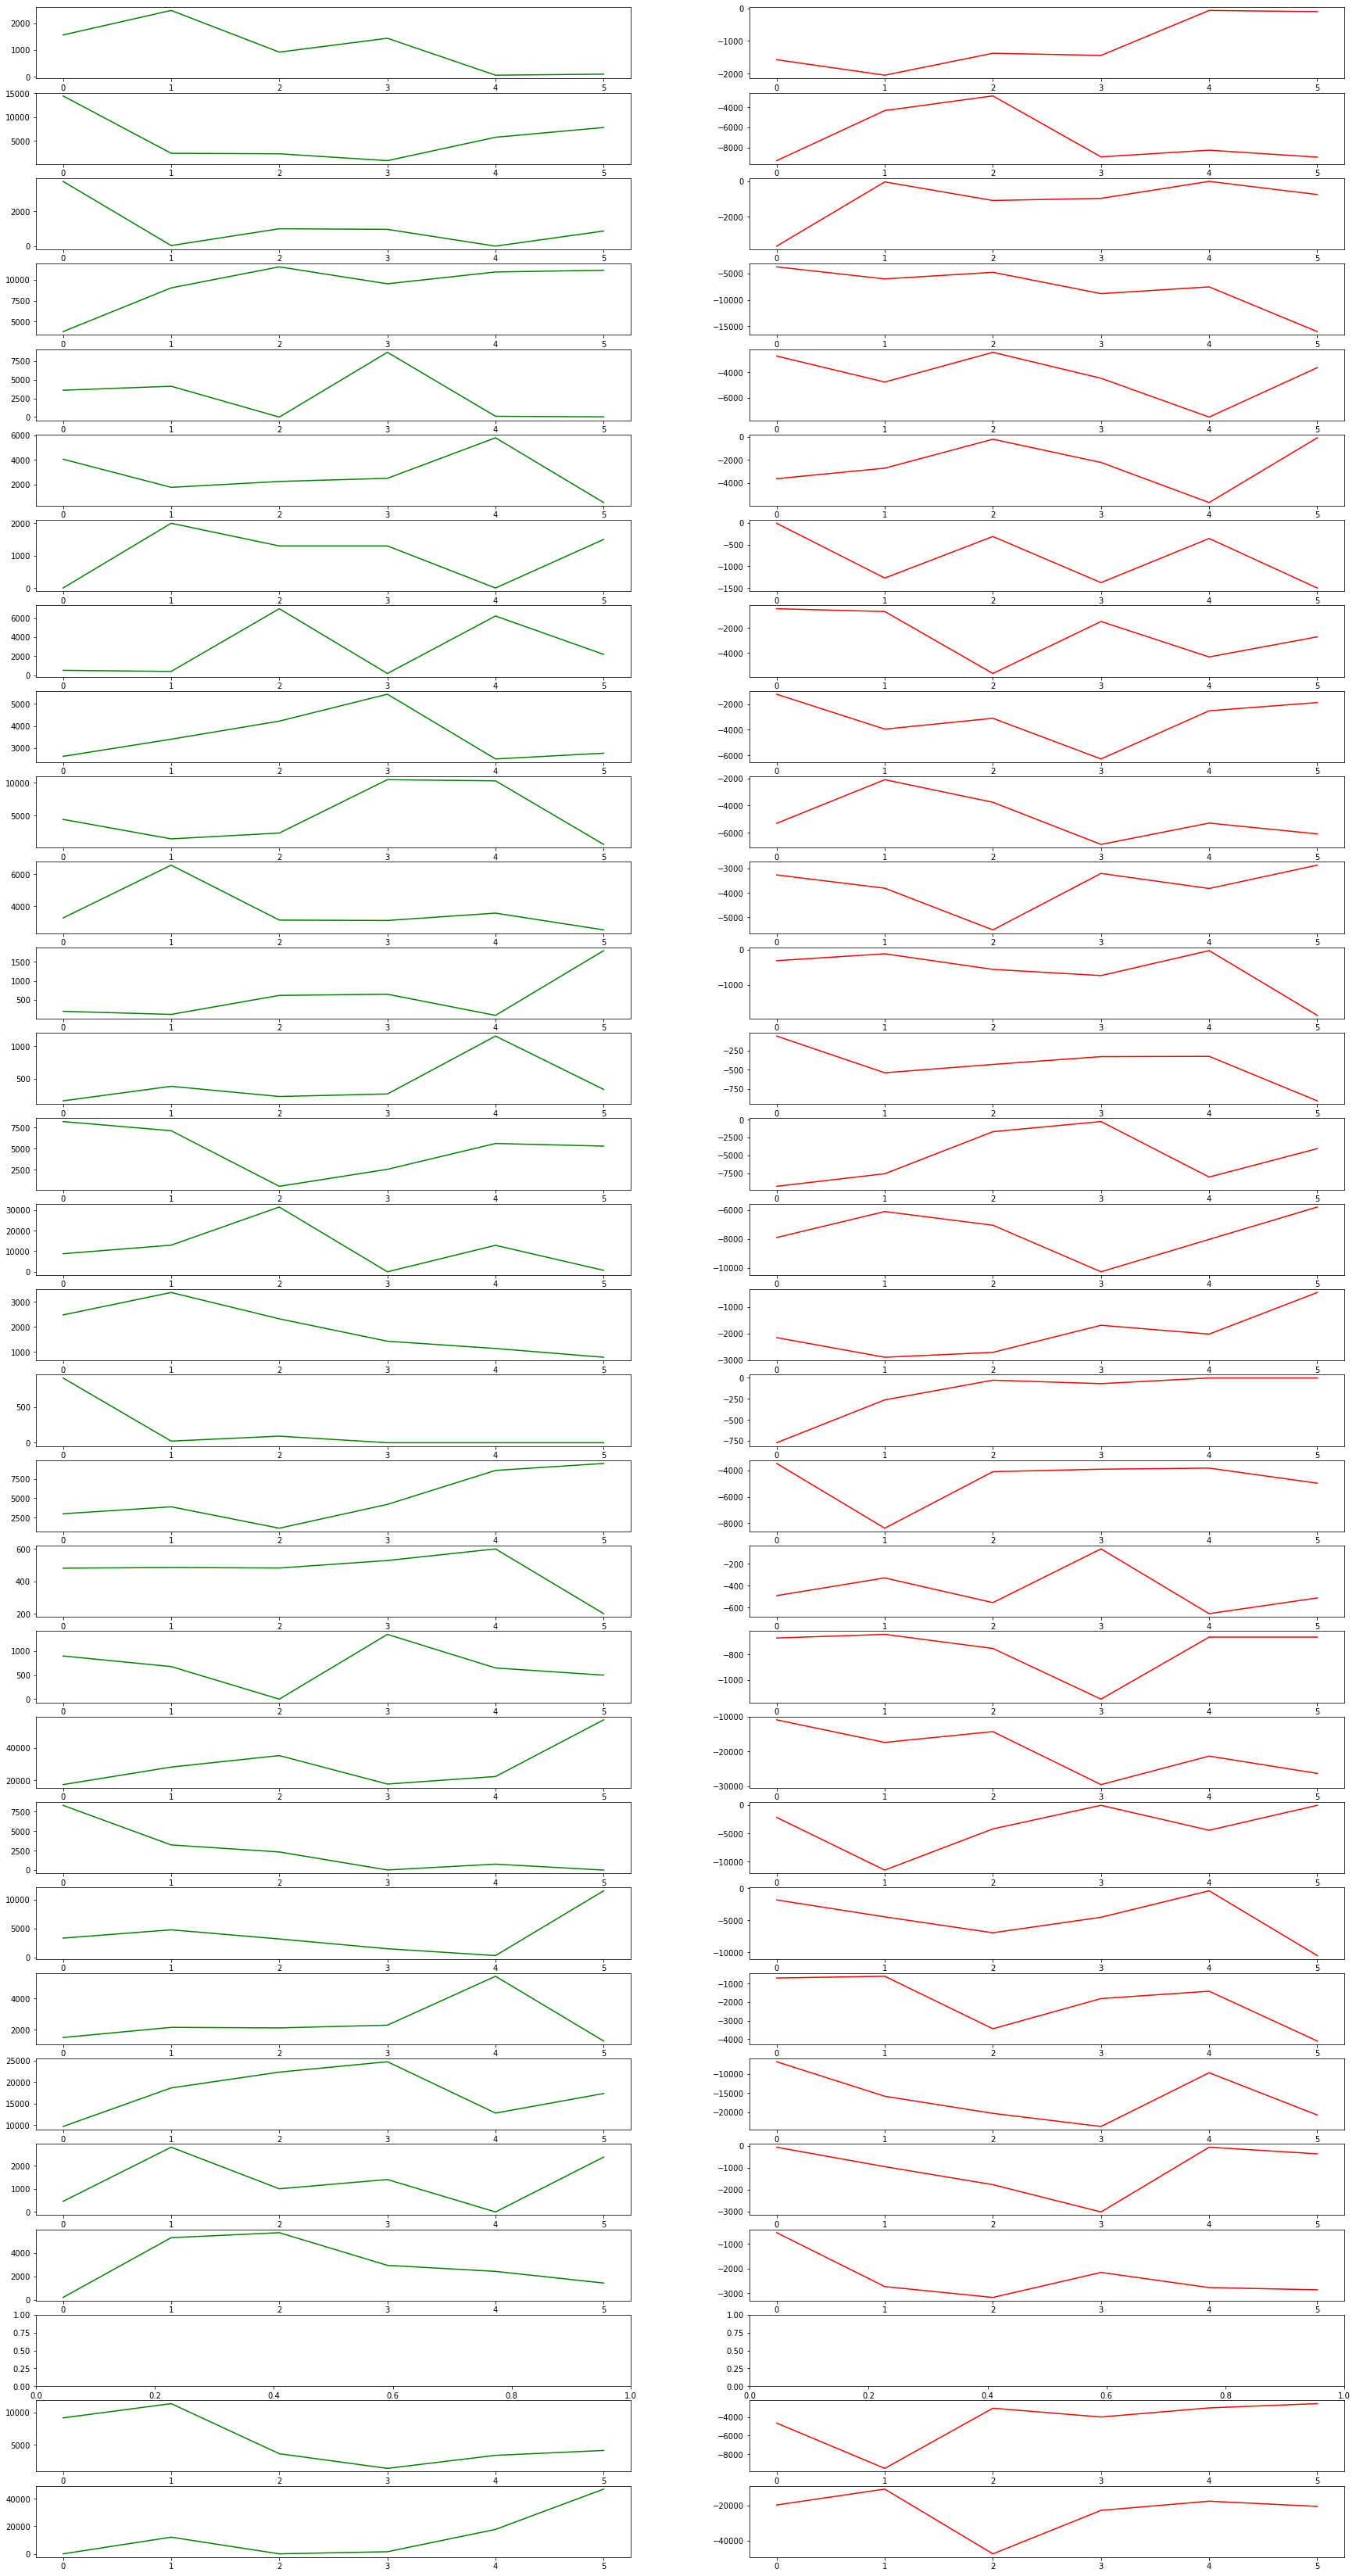

In [21]:
rows = 30
fig, axs = plt.subplots(rows,per_row, figsize=(30,rows*2))
for user_id in range(rows):
    u = User(user_id, accounts, transactions, get_naf_code(user_id))
    # only select users with sufficient history, plots will show up blank
    if u.get_history_length() < 210 or len(u.account_history) < 20:
        continue
    v = UserDataExtractor(u)
    filled_hist = v.filled_history
    expense = []
    income = []
    
    to_d = v.end_date - np.timedelta64(30, 'D')
    for month_back in range(5, -1, -1):
        month_start = to_d - np.timedelta64(month_back * 30, 'D')
        month_end = month_start + np.timedelta64(30, 'D')
        timeframe = filled_hist[month_start:month_end]

        expense.append(v.calculate_expense(timeframe))
        income.append(v.calculate_income(timeframe))
    
    axs[user_id, 0].plot(income, color='green')
    axs[user_id, 1].plot(expense, color='red')


#### Conclusion

The correlation between income and expense is clear, the (negative) expense decreases when the income increases. There seems to be a lagged causal effect where the income of month 0 increases the expense of month 1. It might be that the expense of month 0 predicts the income of month 1, as individuals might spend more knowing they have a fruitful month ahead.

Expense is relatively stable. Some insights:

    - Usually no short term trend => We don't necessarily need a timeseries methods
    - A Naive predictor would probably do quite well => Prioritise simple models

#### NAF Business Code

Not all codes are present within the users. There is a lot of potential information encoded in the NAF code.

In [313]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Only 100 different codes appear

In [305]:
user_codes = users['business_NAF_code']
len(user_codes.unique())get_naf_code

100

3 potential features emerge from the data:
- full code (100 different codes hence label encoding)
- last letter of code(only 6 different letters, one-hot encoding)
- The first word in the description (at least 20, label encoding)

In [341]:
present_codes = business_naf.loc[np.isin(business_naf['code'],user_codes)]
present_codes

,name,code
19,Élevage de chevaux et d'autres équidés,0143Z
21,Élevage d'ovins et de caprins,0145Z
26,Activités de soutien aux cultures,0161Z
79,Fabrication de pâtes alimentaires,1073Z
120,"Sciage et rabotage du bois, hors imprégnation",1610A
...,...,...
716,Réparation d'ordinateurs et d'équipements péri...,9511Z
717,Réparation d'équipements de communication,9512Z
726,Coiffure,9602A
727,Soins de beauté,9602B


###### Encoding the last letter

In [20]:
last_letters = [code[-1] for code in users['business_NAF_code']]
unique_last_letters = list(set(last_letters))

In [21]:
unique_last_letters

['F', 'C', 'A', 'D', 'B', 'Z']

In [430]:
one_hot_last_letter = OneHotEncoder().fit(pd.DataFrame(unique_last_letters))
users = pd.concat([users, pd.DataFrame(one_hot_last_letter.transform(pd.DataFrame(last_letters)).toarray())], axis=1)

In [440]:
pd.DataFrame(one_hot_last_letter.transform(pd.DataFrame(['A'])).toarray()[0]).T

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0


In [371]:
users

,id,update_date,business_NAF_code,0,1,2,3,4,5,naf_code
0,0,2020-09-27,8219Z,0.0,0.0,0.0,0.0,0.0,1.0,80
1,1,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52
2,2,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52
3,3,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52
4,4,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52
...,...,...,...,...,...,...,...,...,...,...
338,338,2020-09-26,4719B,0.0,1.0,0.0,0.0,0.0,0.0,23
339,339,2020-09-26,4331Z,0.0,0.0,0.0,0.0,0.0,1.0,11
340,340,2020-09-27,5320Z,0.0,0.0,0.0,0.0,0.0,1.0,39
341,341,2020-09-27,2562B,0.0,1.0,0.0,0.0,0.0,0.0,5


##### Next we encode the actual naf code using a label encoder

In [366]:
df_unique_codes  = pd.DataFrame(user_codes.unique())
df_codes = pd.DataFrame(user_codes.values)

In [367]:
label_enc= LabelEncoder().fit(pd.DataFrame(user_codes.unique()))

C:\Users\oscar\anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [432]:
users['naf_code'] = label_enc.transform(df_codes)
label_enc.transform(df_codes)

C:\Users\oscar\anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([80, 52, 52, 52, 52, 62, 52, 12, 52, 46, 83, 36, 62, 52, 52, 39, 59,
       95, 62, 88, 86, 52, 51, 83, 52, 62, 53, 66, 64, 62, 73, 54, 62, 53,
       62, 93, 62, 53,  9, 21,  8, 42, 43, 53, 16, 52, 62, 33, 56, 90, 89,
       94, 61, 52, 68, 62, 62, 53, 13, 36, 52, 13, 99, 42, 17, 40, 65, 71,
       28, 36, 47, 29, 20, 53, 34, 39, 54, 36, 11, 21, 62, 52, 53, 39, 52,
       86, 36, 67, 42, 10, 79, 62, 59, 36, 39, 62,  4, 43, 35, 62, 87,  9,
       62, 36, 36, 35, 60, 52, 62, 84, 70, 62, 90, 25, 26, 41, 13, 36, 82,
       39, 73, 25, 35, 19, 22, 61, 53, 17, 12, 61, 19, 48, 19, 53, 39, 81,
       78, 84, 34, 76, 76, 36, 36, 39, 39, 62, 63, 53, 62, 39, 62, 25, 50,
        9, 14, 53, 34, 98, 19, 13, 66, 33, 33, 63, 39, 36, 26, 67, 67, 52,
       39, 29, 52, 99, 69, 53, 39, 76, 34, 18, 18, 36, 21, 12, 17, 27, 62,
       96, 39, 39,  7, 39, 36, 18, 39, 45, 36, 52, 59, 62, 59, 53, 39, 33,
       74,  9, 36, 62, 33, 33, 39, 75, 25, 39, 39, 52, 62, 56, 91, 36, 92,
       33, 21, 36, 91, 18

##### Idea: The first word of each category contains most of the information (Réparation, Élevage, Recherche...)

In [22]:
def get_job_type(naf_code):
    try:
        job_name = business_naf.loc[business_naf['code'] == naf_code]['name'].values[0]
        return job_name.replace(',',' ').split()[0]
    except:
        return 'Unknown'

In [424]:
get_job_type('8690F')

'Unknown'

In [416]:
job_types = [get_job_type(code) for code in users['business_NAF_code'].unique()]
unique_job_types = list(set(job_types))
job_types

['Photocopie',
 'Programmation',
 'Conseil',
 'Travaux',
 'Production',
 'Enseignement',
 'Transports',
 'Autres',
 'Agences',
 'Réparation',
 'Activités',
 'Formation',
 'Autres',
 'Conseil',
 'Activités',
 'Recherche-développement',
 'Activités',
 'Tierce',
 'Gestion',
 'Travaux',
 'Autres',
 'Construction',
 'Restauration',
 'Services',
 'Travaux',
 'Vente',
 'Autres',
 'Arts',
 'Unknown',
 'Autres',
 'Conseil',
 'Activités',
 'Travaux',
 'Autres',
 'Travaux',
 'Hébergement',
 'Activités',
 'Autre',
 'Commerce',
 'Production',
 'Autres',
 'Commerce',
 'Vente',
 'Travaux',
 'Activités',
 'Travaux',
 'Services',
 'Sciage',
 'Vente',
 'Autres',
 'Activités',
 'Enseignement',
 'Location',
 'Commerce',
 'Commerce',
 'Restauration',
 'Autres',
 'Entretien',
 'Commerce',
 'Post-production',
 'Organisation',
 'Services',
 'Nettoyage',
 'Ingénierie',
 'Édition',
 'Travaux',
 'Soins',
 'Location',
 'Commerce',
 'Commerce',
 'Réparation',
 'Autres',
 'Édition',
 'Activités',
 'Activités',
 'Cr

In [417]:
job_type_enc = LabelEncoder().fit(pd.DataFrame(unique_job_types))

C:\Users\oscar\anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [418]:
users['job_type'] = job_type_enc.transform(users['business_NAF_code'].apply(get_job_type))

In [419]:
users

,id,update_date,business_NAF_code,0,1,2,3,4,5,naf_code,job_type
0,0,2020-09-27,8219Z,0.0,0.0,0.0,0.0,0.0,1.0,80,22
1,1,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52,25
2,2,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52,25
3,3,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52,25
4,4,2020-09-27,6201Z,0.0,0.0,0.0,0.0,0.0,1.0,52,25
...,...,...,...,...,...,...,...,...,...,...,...
338,338,2020-09-26,4719B,0.0,1.0,0.0,0.0,0.0,0.0,23,4
339,339,2020-09-26,4331Z,0.0,0.0,0.0,0.0,0.0,1.0,11,34
340,340,2020-09-27,5320Z,0.0,0.0,0.0,0.0,0.0,1.0,39,4
341,341,2020-09-27,2562B,0.0,1.0,0.0,0.0,0.0,0.0,5,19


### Conclusion

    1. This problem does not seem suited to a timeseries forecasting method but rather to a simple regression model for the following reasons:
        - No seasonality and almost no short term trend
        - Uneven data (or sparse if user history is filled in)
        - Relatively simple problem 
        - Multiple time series to forecast with many external features (makes it harder to deal with timeseries methods)
        - Potential for feature engineering
        
    2. NAF code contains a lot of information, however looking back at the categories, I am not convinced the final letter of the codes will yield much predictive power
    
    3. Predicting Income and Expense are very linked and I suspect very similar approaches will lead to similar results. However predicting expnses seems like the most interesting problem to me so I will focus on Option B.